# Khai báo thư viện

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
#------------------------------------------------------------------
from sklearn import preprocessing #has preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#------------------------------------------------------------------
from scipy.stats import uniform
#------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import 
# from sklearn.model_selection import 
#------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
#------------------------------------------------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import make_scorer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Data

In [16]:
df = pd.read_csv("D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Mall Customers\Mall_Customers_preprocessed.csv")

In [17]:
df.head()

,customerid,age,annual_income,spending_score,genre_Female
0,1,-1.424569,-1.738999,-0.434801,0.0
1,2,-1.281035,-1.738999,1.195704,0.0
2,3,-1.352802,-1.700830,-1.715913,1.0
3,4,-1.137502,-1.700830,1.040418,1.0
4,5,-0.563369,-1.662660,-0.395980,1.0


In [18]:
data = df.drop(columns=["customerid",],axis=1,)

In [19]:
X = data.copy()

# AP

## 1. Algorithm's parameters

```
damping
preference
```

In [29]:
ap = AffinityPropagation(random_state=42 ,damping=0.56, preference=-64.450)
ap.fit(X)

AffinityPropagation(damping=0.56, preference=-64.45, random_state=42)

## 2. Cluster Visualization

In [30]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

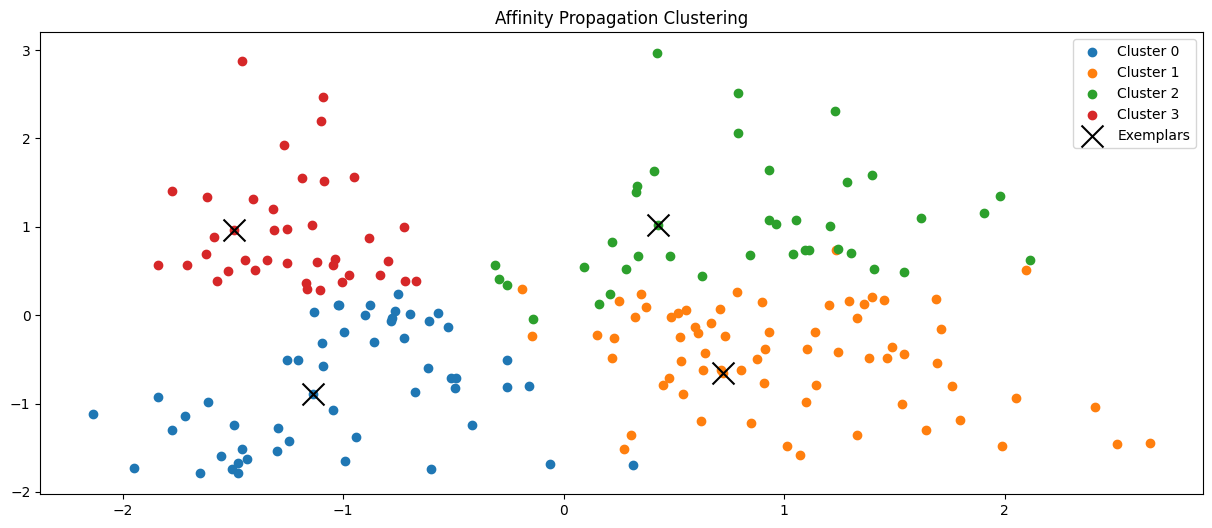

In [31]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(15, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Hyperparameter Optimization

## Random Search

In [23]:
#Khởi tạo biến lưu trữ kết quả
best_score = -1
best_damping= None
best_pref= None
best_model = None
best_n_clusters = None
best_labels = None

#Thực hiện Random Search
for _ in range(20):
    damp = np.random.uniform(0.5, 0.9)
    pref = np.random.uniform(-300, 0)

    model = AffinityPropagation(
        damping=damp,
        preference=pref,
        random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        continue  # Bỏ qua trường hợp không hợp lệ

    score = silhouette_score(X, labels)

    if score > best_score:
        best_score = score
        best_damping = damp
        best_pref = pref
        best_model = model
        best_n_clusters = n_clusters
        best_labels = labels

#Tính các chỉ số đánh giá với tham số tốt nhất
silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)


In [24]:
print("\nKết quả tốt nhất từ [Random Search]:")
print("-Tham số tối ưu:")
print(f"\t+ Damping: {best_damping:.3f}")
print(f"\t+ Preference: {best_pref:.3f}")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldie Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")


Kết quả tốt nhất từ [Random Search]:
-Tham số tối ưu:
	+ Damping: 0.560
	+ Preference: -64.450
- Số lượng cụm: 4
- Silhouette Score: 0.345
- Davies Bouldie Score: 1.083
- Calinski Harabasz Score: 99.483


## Bayesian Optimization

In [25]:
def objective(trial):
    damping = trial.suggest_float('damping', 0.5, 0.9)
    preference = trial.suggest_float('preference', -300, 0)

    model = AffinityPropagation(
        damping=damping,
        preference=preference,
        random_state=42
    )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        return 0.0
    
    score = silhouette_score(X, labels)

    #Quyết định cắt bỏ trial này
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return score #Vì Optuna maximize

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-07 16:05:09,326] A new study created in memory with name: no-name-dde62358-baa5-47a1-8655-3b4af0ba938b
[I 2025-05-07 16:05:09,343] Trial 0 finished with value: 0.3097124824523156 and parameters: {'damping': 0.8562045983126751, 'preference': -22.3685566424773}. Best is trial 0 with value: 0.3097124824523156.
[I 2025-05-07 16:05:09,354] Trial 1 finished with value: 0.33599406751437544 and parameters: {'damping': 0.6566976192931009, 'preference': -27.525383886204338}. Best is trial 1 with value: 0.33599406751437544.
[I 2025-05-07 16:05:09,365] Trial 2 finished with value: 0.2943708379712696 and parameters: {'damping': 0.8640182410153106, 'preference': -179.94392209329465}. Best is trial 1 with value: 0.33599406751437544.
[I 2025-05-07 16:05:09,376] Trial 3 finished with value: 0.3465967555898763 and parameters: {'damping': 0.7048050602226211, 'preference': -105.90173190471467}. Best is trial 3 with value: 0.3465967555898763.
[I 2025-05-07 16:05:09,386] Trial 4 finished with val

In [27]:
best = study.best_params

best_model = AffinityPropagation(
    damping=best['damping'],
    preference=best['preference'],
    random_state=42
)

best_labels = best_model.fit_predict(X)
best_n_clusters = len(set(best_labels))

silhouette_ap = silhouette_score(X, best_labels)
davies_bouldin_ap = davies_bouldin_score(X, best_labels)
calinski_harabasz_ap = calinski_harabasz_score(X, best_labels)

In [28]:
print("\nKết quả tốt nhất từ [Bayesian Optimization]:")
print("-Tham số tối ưu:")
print(f"\t+ Damping: {best['damping']:.3f}")
print(f"\t+ Preference: {best['preference']:.3f}")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {silhouette_ap:.3f}")
print(f"- Davies Bouldie Score: {davies_bouldin_ap:.3f}")
print(f"- Calinski Harabasz Score: {calinski_harabasz_ap:.3f}")


Kết quả tốt nhất từ [Bayesian Optimization]:
-Tham số tối ưu:
	+ Damping: 0.820
	+ Preference: -1.708
- Số lượng cụm: 31
- Silhouette Score: 0.375
- Davies Bouldie Score: 0.827
- Calinski Harabasz Score: 78.943
